#Tasks

1. write a code for trigular wave generator
2. create the custom resnet model
3. find lrmin and lrmax
4. Don't use Annihilation
5. Use horiflip, cutout, crop in image augmentation

--------------------------------------------------------------------

##Achieved : **89%** using Custom Resnet model with Albumentation 

Remarks:
Learnings:
1. calculating Step up and step down for cyclicLR depending on the iterations
2. checked with OnecycleLR and studied on hyperparameters
3. LRfinder using nll_loss gave good results, need to check why not using crossentropy




In [3]:
! pip install albumentations==0.4.6

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


In [6]:
import sys
import os
sys.path.append('/content/gdrive/')
py_file_location = "/content/drive/My Drive/S11_CyclicLR/"
sys.path.append(os.path.abspath(py_file_location))

In [7]:
%cd '/content/drive/My Drive/S11_CyclicLR'
!pwd
!ls

/content/drive/My Drive/S11_CyclicLR
/content/drive/My Drive/S11_CyclicLR
data			 s11_displays.py	  s11_test_file.py
__pycache__		 s11_gradcam.py		  s11_train_file.py
s11_cifar_dataloader.py  s11_lrfinder.py
s11_cifar_modelfile.py	 s11_mainfile_cifar10.py


In [8]:
# Import your module or file
from s11_cifar_modelfile import Net, ResNet18, CustomResNet
from s11_cifar_dataloader import AlbumentationsDataset
from s11_train_file import customTraining
from s11_test_file import customTest
from s11_gradcam import GradCam
from s11_lrfinder import LRFinder 
from s11_displays import customPlots

In [9]:
%matplotlib inline

In [10]:
import torch
import torchvision
import torchvision.transforms as transforms

In [11]:
SEED = 1
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


##------------------------Call to Data Loader-------------------------

Albumentation method for data augmentation 
### use of Cutout in augmentation

In [12]:
import albumentations as A
aclass = AlbumentationsDataset()
input_batch_size =512

custom_train_tfms = [A.PadIfNeeded(min_height=4,min_width=4), 
                     A.RandomCrop(32, 32, p=1.0),
                     A.HorizontalFlip(),
                     A.Cutout(num_holes=8, max_h_size=8, max_w_size=8, fill_value=0, always_apply=False, p=0.1),
                     ]
trainset, trainloader, testset, testloader, classes = aclass.cifar10dataWithAugmentation(input_batch_size, custom_train_tfms)

Files already downloaded and verified
Files already downloaded and verified


##------------------ Visualize Input Image ---------------------------- 

---



---


Let us show some of the training images, for fun.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 3, 32, 32)


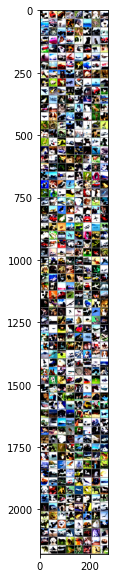

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy() 
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# # get some random training images
dataiter = iter(trainloader)
images, labels =  dataiter.next()
print(images.numpy().shape)  

plt.figure(figsize=(20,10))
# show images
imshow(torchvision.utils.make_grid(images))

##  ------------------------------Getting Resnet18 network from model file----------------------- 

1. Get the model
2. print summary
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [14]:
# load to device and print model summary
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
# call now Resnet18 model
model = CustomResNet().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
       BasicBlock-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         294,912
        MaxPool2d-14            [-

##------------------------------Calling training and testing  -------------------------

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.02E-03


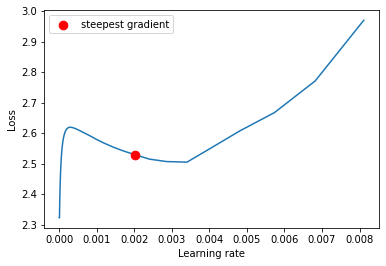

In [12]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

model = CustomResNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-7)#, weight_decay=0.1)
criterion = F.nll_loss #nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device="cuda" )
lr_finder.range_test(train_loader=trainloader,val_loader=testloader, end_lr=3, num_iter=100)#, step_mode="linear"
lr_finder.plot(log_lr=False)
lr_finder.reset()

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.48E-01


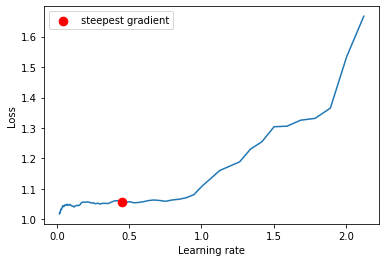

In [12]:
import torch.nn as nn
import torch.optim as optim

#model = CustomResNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)#weight_decay=0.0
criterion = F.nll_loss
lr_finder = LRFinder(model, optimizer, criterion, device="cuda" )
lr_finder.range_test(train_loader=trainloader,end_lr=3, num_iter=100)
lr_finder.plot(log_lr=False)
lr_finder.reset()

Total training samples = 50000

batch size = 512

total iteration/epoch = 50000/512 = 97.65  approx = 98

total iteration for 5 epochs(to get maxLR) = 488.25 approx = 490 as 98*5

total iteration for 19 epochs (for step down) = 1855    considering approx = 98*19 = 1862


In [16]:
import torch.optim as optim
from torch.optim.lr_scheduler import CyclicLR, OneCycleLR
import torch.nn as nn
import torch.nn.functional as F

# train_loss = 0
# train_acc=0
# test_loss = 0
# test_acc= 0 

train_losses, train_accs=[],[]
test_losses, test_accs=[],[]

criterion = nn.CrossEntropyLoss()
model =  CustomResNet().to(device)#ResNet18().to(device)


lr_max=  4.48E-01#8.95E-01 #1.78E-02
lr_min = 2.02E-03 #1.70E-03

trainClass = customTraining(train_loader= trainloader,model=model,loss_func=criterion,device=device)
testClass = customTest(test_loader=testloader,model=model,loss_func=F.cross_entropy,device=device)

optimizer = optim.SGD(model.parameters(), lr=lr_min)
lr_scheduler = CyclicLR(optimizer, base_lr=lr_min, max_lr=lr_max, step_size_up=490, step_size_down=1862)
#lr_scheduler = OneCycleLR(optimizer, pct_start = 0.2, max_lr = lr_max, steps_per_epoch = 98, epochs=24, anneal_strategy= 'linear')

EPOCHS = 24
for epoch in range(EPOCHS):
    #print("EPOCH:", epoch)
    print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))
    train_losses, train_accs = trainClass.trainWithLRStepping(optimizer,lr_scheduler)
    test_losses, test_accs = testClass.test()
    #lr_scheduler.step(test_losses[-1])
    #lr_scheduler.step()

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch-0 lr: 0.00202


Loss=2.565117359161377 Batch_id=97 Accuracy=15.15: 100%|██████████| 98/98 [00:25<00:00,  3.89it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 3.3828, Accuracy: 2135/10000 (21.35%)

Epoch-1 lr: 0.09121600000000014


Loss=1.7609971761703491 Batch_id=97 Accuracy=28.30: 100%|██████████| 98/98 [00:26<00:00,  3.77it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.8805, Accuracy: 3540/10000 (35.40%)

Epoch-2 lr: 0.18041199999999982


Loss=1.4201078414916992 Batch_id=97 Accuracy=46.31: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.4504, Accuracy: 5123/10000 (51.23%)

Epoch-3 lr: 0.269608


Loss=0.9354349970817566 Batch_id=97 Accuracy=58.65: 100%|██████████| 98/98 [00:25<00:00,  3.88it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.1417, Accuracy: 6196/10000 (61.96%)

Epoch-4 lr: 0.3588040000000001


Loss=0.8147420287132263 Batch_id=97 Accuracy=68.33: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.8423, Accuracy: 7231/10000 (72.31%)

Epoch-5 lr: 0.4479999999999998


Loss=0.6576142907142639 Batch_id=97 Accuracy=74.54: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7347, Accuracy: 7569/10000 (75.69%)

Epoch-6 lr: 0.42452736842105265


Loss=0.5816787481307983 Batch_id=97 Accuracy=79.29: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6336, Accuracy: 7877/10000 (78.77%)

Epoch-7 lr: 0.40105473684210524


Loss=0.5470909476280212 Batch_id=97 Accuracy=82.40: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6031, Accuracy: 7999/10000 (79.99%)

Epoch-8 lr: 0.377582105263158


Loss=0.4385250210762024 Batch_id=97 Accuracy=85.06: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5357, Accuracy: 8212/10000 (82.12%)

Epoch-9 lr: 0.35410947368421053


Loss=0.3383578360080719 Batch_id=97 Accuracy=86.79: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4993, Accuracy: 8375/10000 (83.75%)

Epoch-10 lr: 0.3306368421052632


Loss=0.33101630210876465 Batch_id=97 Accuracy=88.53: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5098, Accuracy: 8363/10000 (83.63%)

Epoch-11 lr: 0.3071642105263159


Loss=0.3086349070072174 Batch_id=97 Accuracy=90.08: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4871, Accuracy: 8459/10000 (84.59%)

Epoch-12 lr: 0.28369157894736846


Loss=0.2613948583602905 Batch_id=97 Accuracy=91.78: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4854, Accuracy: 8564/10000 (85.64%)

Epoch-13 lr: 0.26021894736842116


Loss=0.20664122700691223 Batch_id=97 Accuracy=92.93: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5774, Accuracy: 8421/10000 (84.21%)

Epoch-14 lr: 0.2367463157894736


Loss=0.12883375585079193 Batch_id=97 Accuracy=93.77: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4970, Accuracy: 8615/10000 (86.15%)

Epoch-15 lr: 0.2132736842105263


Loss=0.19341135025024414 Batch_id=97 Accuracy=94.96: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5123, Accuracy: 8609/10000 (86.09%)

Epoch-16 lr: 0.18980105263157904


Loss=0.1464587152004242 Batch_id=97 Accuracy=95.67: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5575, Accuracy: 8597/10000 (85.97%)

Epoch-17 lr: 0.1663284210526315


Loss=0.11506932228803635 Batch_id=97 Accuracy=96.30: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5287, Accuracy: 8683/10000 (86.83%)

Epoch-18 lr: 0.1428557894736842


Loss=0.07674811780452728 Batch_id=97 Accuracy=96.95: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5094, Accuracy: 8747/10000 (87.47%)

Epoch-19 lr: 0.11938315789473693


Loss=0.08669814467430115 Batch_id=97 Accuracy=97.14: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5252, Accuracy: 8823/10000 (88.23%)

Epoch-20 lr: 0.09591052631578939


Loss=0.053581565618515015 Batch_id=97 Accuracy=97.59: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5133, Accuracy: 8807/10000 (88.07%)

Epoch-21 lr: 0.0724378947368421


Loss=0.07026058435440063 Batch_id=97 Accuracy=97.80: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5023, Accuracy: 8839/10000 (88.39%)

Epoch-22 lr: 0.04896526315789482


Loss=0.05235602706670761 Batch_id=97 Accuracy=98.05: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5031, Accuracy: 8845/10000 (88.45%)

Epoch-23 lr: 0.025492631578947288


Loss=0.0912943184375763 Batch_id=97 Accuracy=98.19: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s]



Test set: Average loss: 0.4960, Accuracy: 8850/10000 (88.50%)



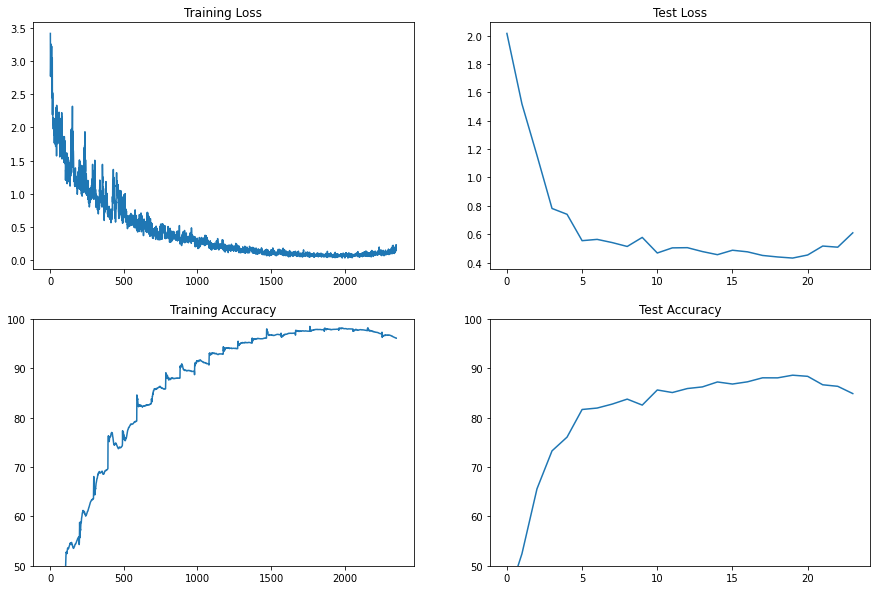

In [14]:
#call plot functions

# print(test_losses)
# print(train_losses)
# print(train_accs)
dispFuns = customPlots(train_losses=train_losses, train_acc=train_accs, test_losses=test_losses, test_acc=test_accs)
dispFuns.plot_losses()
